In [25]:
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord,SphericalDifferential,ICRS,Galactic,GalacticLSR,Distance
from astropy.table import Table
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad
import pandas as pd
from astropy.table import Table, join,vstack
import numpy as np
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import codecs
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
%config InlineBackend.figure_format='retina'


from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams["mathtext.fontset"] = 'stix'

## Stellar Wind: VelaOB2 massive B star 

download table with mass and Teff info: \
https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

Full information including giants: \
http://www.isthe.com/chongo/tech/astro/HR-temp-mass-table-byhrclass.html

In [ ]:
star_type_info = ascii.read('/Users/anniegao/Desktop/EEM_dwarf_UBVIJHK_colors_Teff.txt', delimiter=r'\s', fill_values=[('...', '0', 'precip'), ('.....', '0', 'precip')])
star_type_info['SpT'].value

array(['O3V', 'O4V', 'O5V', 'O5.5V', 'O6V', 'O6.5V', 'O7V', 'O7.5V',
       'O8V', 'O8.5V', 'O9V', 'O9.5V', 'B0V', 'B0.5V', 'B1V', 'B1.5V',
       'B2V', 'B2.5V', 'B3V', 'B4V', 'B5V', 'B6V', 'B7V', 'B8V', 'B9V',
       'B9.5V', 'B0Ia0', 'B1IV', 'B2II', 'B2III', 'B2IV', 'B3II', 'B3III',
       'B5III', 'B5IV', 'B5Ib', 'B7II', 'B7III', 'B7IV', 'B8IV', 'B8II',
       'B8III', 'B9II', 'B9IV', 'A0V', 'A1V', 'A2V', 'A3V', 'A4V', 'A5V',
       'A6V', 'A7V', 'A8V', 'A9V', 'F0V', 'F1V', 'F2V', 'F3V', 'F4V',
       'F5V', 'F6V', 'F7V', 'F8V', 'F9V', 'F9.5V', 'G0V', 'G1V', 'G2V',
       'G3V', 'G4V', 'G5V', 'G6V', 'G7V', 'G8V', 'G9V', 'K0V', 'K1V',
       'K2V', 'K3V', 'K4V', 'K5V', 'K6V', 'K7V', 'K8V', 'K9V', 'M0V',
       'M0.5V', 'M1V', 'M1.5V', 'M2V', 'M2.5V', 'M3V', 'M3.5V', 'M4V',
       'M4.5V', 'M5V', 'M5.5V', 'M6V', 'M6.5V', 'M7V', 'M7.5V', 'M8V',
       'M8.5V', 'M9V', 'M9.5V', 'L0V', 'L1V', 'L2V', 'L3V', 'L4V', 'L5V',
       'L6V', 'L7V', 'L8V', 'L9V', 'T0V', 'T1V', 'T2V', 'T3V', 'T4V'

In [3]:
ob_young = fits.open('/Users/anniegao/Documents/dustmaps_files/DeZeeuw_OB_assoc.fit')[1].data
velaOB2 = ob_young[(ob_young['OBAss']=='D')&(ob_young['Type']=='e')]

In [6]:
v = Vizier(columns=['HIP', 'Vmag','Plx', 'B-V', 'SpType'], catalog="I/239/hip_main")
out =v.query_object(f"HIP {velaOB2['HIP'][0]}")[0]
for i in range(1, len(velaOB2['HIP'])):
    if i!= 26 and i!=37 and i!=83:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        out.add_row([que['HIP'], que['Vmag'], que['Plx'], que['B-V'], que['SpType']])
    elif i== 83:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        out.add_row([que[0]['HIP'], que[0]['Vmag'], que[0]['Plx'], que[0]['B-V'], que[0]['SpType']])
    else:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        out.add_row([que[1]['HIP'], que[1]['Vmag'], que[1]['Plx'], que[1]['B-V'], que[1]['SpType']])

In [7]:
cut = out.copy()
cut.remove_row(50)
mask_B = [(item.startswith('B')) for item in cut['SpType']] # and int(item[1]) < 4 and item[2]=='V'
cut = cut[mask_B]
cut['SpType'][:]= ['B9V', 'B9IV', 'B9V', 'B3III', 'B9IV', 'B5IV','B3II', 'B5V', 'B6V', 'B6V', 'B7IV', 'B1V',
                   'B3III', 'B9II', 'B2IV', 'B8IV', 'B2IV', 'B6V','B8II', 'B2V', 'B5V', 'B8V', 'B1V', 'B9V', 'B8V',
                   'B5V', 'B7III', 'B9IV', 'B7V', 'B2IV', 'B9IV','B2III', 'B9V', 'B5III', 'B9V', 'B8V', 'B8V',
                   'B3V', 'B8V', 'B3III', 'B9V', 'B8V', 'B7V', 'B9IV', 'B9V', 'B1IV', 'B8V', 'B8IV', 'B5V',
                   'B2IV', 'B3V', 'B9V', 'B9V', 'B9V', 'B5V','B7III', 'B9IV', 'B1V', 'B9V', 'B9.5V', 'B9V', 'B5IV',
                   'B8III', 'B9IV', 'B9V', 'B8V', 'B9V', 'B6V','B2IV', 'B2V', 'B8V', 'B2.5V', 'B9V', 'B2II',
                   'B5V', 'B7III', 'B7IV', 'B3V', 'B9IV', 'B5Ib']

In [ ]:
spType, counts = np.unique(cut['SpType'].value, return_counts=True)
Lw = 0
for i, sp in enumerate(spType):
    print(sp)
    logL_star = float(star_type_info[star_type_info['SpT']==sp]['logL'])
    logM_star = np.log10(float(star_type_info[star_type_info['SpT']==sp]['Msun']))
    logTeff_star = float(star_type_info[star_type_info['SpT']==sp]['logT'])
    log_dM = -24.06 + 2.45*logL_star - 1.10*logM_star +1.31*logTeff_star
    log_v = 1.23 - 0.30*logL_star + 0.55*logM_star + 0.64*logTeff_star
    dM = 10**(log_dM)
    print(dM)
    v = 10**(log_v)
    print(v)
    Lw_element = 0.5*dM*(v**2)
    print('Lw_element',Lw_element)
    Lw += Lw_element*counts[i] # unit: 

B1IV
3.2173484353934423e-09
2482.0524318207217
Lw_element 0.009910373088025792
B1V
4.6034114327088736e-10
2547.622665433635
Lw_element 0.0014938947613928574
B2.5V
3.20558414576179e-12
2709.0149968690384
Lw_element 1.1762509964284837e-05
B2II
2.0714564229870876e-08
2090.6296202861304
Lw_element 0.04526890653970305
B2III
1.3938500583392775e-09
2662.6063977638737
Lw_element 0.004940831058436094
B2IV
7.567408951049043e-10
2570.048965971522
Lw_element 0.002499194200147914
B2V
1.109647026871932e-11
2733.931148482552
Lw_element 4.1469615086163445e-05
B3II
9.221144959171616e-09
2019.7033012562886
Lw_element 0.01880745382927886
B3III
2.596568535328461e-10
2828.0045570574257
Lw_element 0.0010383170949459454
B3V
1.002690416793294e-12
2773.4259060742093
Lw_element 3.856292824946092e-06
B5III
8.323085910374127e-12
3291.302588166561
Lw_element 4.50806328723608e-05
B5IV
4.7014786519821205e-12
3114.5317735318877
Lw_element 2.280289588554841e-05
B5Ib
1.7707376961275813e-08
1532.6143359503621
Lw_element

In [8]:
p_w = 0
for i, sp in enumerate(spType):
    print(sp)
    logL_star = float(star_type_info[star_type_info['SpT']==sp]['logL'])
    logM_star = np.log10(float(star_type_info[star_type_info['SpT']==sp]['Msun']))
    logTeff_star = float(star_type_info[star_type_info['SpT']==sp]['logT'])
    log_dM = -24.06 + 2.45*logL_star - 1.10*logM_star +1.31*logTeff_star
    log_v = 1.23 - 0.30*logL_star + 0.55*logM_star + 0.64*logTeff_star
    dM = 10**(log_dM)
    print(dM)
    v = 10**(log_v)
    print(v)
    pw_element = dM*v
    print('pw_element',pw_element)
    p_w += pw_element*counts[i] # unit: 

B1IV
3.2173484353934423e-09
2482.0524318207217
pw_element 7.985627508082887e-06
B1V
4.6034114327088736e-10
2547.622665433635
pw_element 1.1727755304285449e-06
B2.5V
3.20558414576179e-12
2709.0149968690384
pw_element 8.683975524594315e-09
B2II
2.0714564229870876e-08
2090.6296202861304
pw_element 4.330648155028761e-05
B2III
1.3938500583392775e-09
2662.6063977638737
pw_element 3.7112740828577087e-06
B2IV
7.567408951049043e-10
2570.048965971522
pw_element 1.9448611549727234e-06
B2V
1.109647026871932e-11
2733.931148482552
pw_element 3.033698570586231e-08
B3II
9.221144959171616e-09
2019.7033012562886
pw_element 1.8623976915401697e-05
B3III
2.596568535328461e-10
2828.0045570574257
pw_element 7.343107650620813e-07
B3V
1.002690416793294e-12
2773.4259060742093
pw_element 2.780887577706868e-09
B5III
8.323085910374127e-12
3291.302588166561
pw_element 2.7393794198347e-08
B5IV
4.7014786519821205e-12
3114.5317735318877
pw_element 1.4642904644180182e-08
B5Ib
1.7707376961275813e-08
1532.6143359503621
p

In [ ]:
p_w
p_w_OB2 = (p_w*(u.Msun/u.yr)*(u.km/u.s)*10*u.Myr).to(u.Msun*u.km/u.s)
p_w_OB2

<Quantity 1164.62360048 km solMass / s>

In [11]:
# use Vink 2000 prescription:
# Lw = 0
# for i, sp in enumerate(spType):
#     print(sp)
#     logL_star = float(star_type_info[star_type_info['SpT']==sp]['logL'])
#     logM_star = np.log10(float(star_type_info[star_type_info['SpT']==sp]['Msun']))
#     logTeff_star = float(star_type_info[star_type_info['SpT']==sp]['logT'])
#     log_dM = -24.06 + 2.45*logL_star - 1.10*logM_star +1.31*logTeff_star
#     log_v = 1.23 - 0.30*logL_star + 0.55*logM_star + 0.64*logTeff_star
#     dM = 10**(log_dM)
#     print(dM)
#     v = 10**(log_v)
#     print(v)
#     Lw_element = 0.5*dM*(v**2)
#     print('Lw_element',Lw_element)
#     Lw += Lw_element*counts[i] # unit: 

In [12]:
(Lw*(u.Msun/u.yr)*(u.km/u.s)**2).to(u.erg/u.s)

<Quantity 7.56995709e+34 erg / s>

In [13]:
(Lw*(u.Msun/u.yr)*(u.km/u.s)**2* 10*u.Myr).to(u.erg)

<Quantity 2.38889678e+49 erg>

In [14]:
Lumi_vela = 0
for i, sp in enumerate(spType):
    logL_star = float(star_type_info[star_type_info['SpT']==sp]['logL'])
    Lumi_vela_element = 10**(logL_star)
    Lumi_vela += Lumi_vela_element*counts[i] # unit: 

In [9]:
# O progenitor (general O-type star)
n_sample=100000
dm = np.random.normal(1.78e-7, 0.37e-7, n_sample)*(u.Msun/u.yr)
vt = np.random.normal(2500, 250, n_sample)*(u.km/u.s)
t = np.random.normal(loc=3.e6, scale=0.1e6, size=n_sample)*u.yr
p_gamma_o = dm*vt
p_gamma_o_tot = (p_gamma_o* t).to(u.Msun*u.km/u.s)
np.median(p_gamma_o_tot)

<Quantity 1323.96154274 km solMass / s>

In [7]:
# O star (general O-type star)
n_sample=100000
dm = np.random.normal(1.78e-7, 0.37e-7, n_sample)*(u.Msun/u.yr)
vt = np.random.normal(2500, 250, n_sample)*(u.km/u.s)
t = np.random.normal(loc=3.59e6, scale=0.16e6, size=n_sample)*u.yr
p_gamma_o = dm*vt
p_gamma_o_tot = (p_gamma_o* t).to(u.Msun*u.km/u.s)
lw_O= (1/2 * dm * vt**2).to(u.erg/u.s)
lw_tot_O = (lw_O*t).to(u.erg)

In [16]:
np.percentile(lw_tot_O, 2.5)-np.median(lw_tot_O), np.percentile(lw_tot_O, 97.5)-np.median(lw_tot_O), np.median(lw_tot_O)

(<Quantity -1.88291164e+49 erg>,
 <Quantity 2.71961035e+49 erg>,
 <Quantity 3.89997997e+49 erg>)

In [7]:
# zeta Pup
dm = np.random.normal(2.5e-6, 0.2e-6, n_sample)*(u.Msun/u.yr)
vt = 2250*(u.km/u.s)
t =  np.random.normal(3.2, 0.2, n_sample)*u.Myr
p_zp = (dm*vt).to(u.Msun/u.yr*u.km/u.s)
p_tot_zp = (p_zp*t).to(u.Msun*u.km/u.s)
lw_zp= (1/2 * dm * vt**2).to(u.erg/u.s)
lw_tot_zp = (lw_zp*t).to(u.erg)

In [8]:
np.percentile(lw_tot_zp, 2.5)-np.median(lw_tot_zp), np.percentile(lw_tot_zp, 97.5)-np.median(lw_tot_zp), np.median(lw_tot_zp)
# np.percentile(lw_zp, 2.5)-np.median(lw_zp), np.percentile(lw_zp, 97.5)-np.median(lw_zp), np.median(lw_zp)

(<Quantity -7.660302e+49 erg>,
 <Quantity 8.41779918e+49 erg>,
 <Quantity 4.01933413e+50 erg>)

In [27]:
m_gamma_wr = 1.4e-5 * u.Msun/u.yr
v_gamma_wr = np.random.normal(1500, 20, n_sample) * u.km/u.s
gamma_wr = np.random.normal(1.6, 0.1, n_sample)*1e50*u.erg # total stellar wind energy
gamma_o = lw_tot_O # total stelalr wind energy
p_gamma_wr = m_gamma_wr * v_gamma_wr
p_gamma_wr_tot = (p_gamma_wr * 0.5*u.Myr).to(u.Msun*u.km/u.s)
zeta_pup = lw_tot_zp
vela = 2.3888968e49*u.erg

wind_tot = gamma_wr + gamma_o + zeta_pup + vela
p_wind_tot = p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp + p_w_OB2
print(np.mean(wind_tot), np.mean(p_wind_tot))

6.268018164634013e+50 erg 31268.919280585684 km solMass / s


In [29]:
np.median(gamma_wr + gamma_o + zeta_pup), np.percentile(gamma_wr + gamma_o + zeta_pup, 2.5)-np.median(gamma_wr + gamma_o + zeta_pup), np.percentile(gamma_wr + gamma_o + zeta_pup, 97.5)-np.median(gamma_wr + gamma_o + zeta_pup)

(<Quantity 6.0177624e+50 erg>,
 <Quantity -8.24526864e+49 erg>,
 <Quantity 8.99581985e+49 erg>)

In [30]:
np.median(p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp), np.percentile(p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp, 2.5)-np.median(p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp), np.percentile(p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp, 97.5)-np.median(p_gamma_wr_tot + p_gamma_o_tot + p_tot_zp)

(<Quantity 30057.11982165 km solMass / s>,
 <Quantity -3500.92146204 km solMass / s>,
 <Quantity 3857.81676207 km solMass / s>)

In [11]:
# np.median(p_gamma_wr_tot)
# np.percentile(p_gamma_wr_tot, 2.5)-np.median(p_gamma_wr_tot), np.percentile(p_gamma_wr_tot, 97.5)-np.median(p_gamma_wr_tot), np.median(p_gamma_wr_tot)
# np.percentile(p_gamma_o_tot, 2.5)-np.median(p_gamma_o_tot), np.percentile(p_gamma_o_tot, 97.5)-np.median(p_gamma_o_tot), np.median(p_gamma_o_tot)
# np.percentile(p_tot_zp, 2.5)-np.median(p_tot_zp), np.percentile(p_tot_zp, 97.5)-np.median(p_tot_zp), np.median(p_tot_zp)
# np.percentile(p_wind_tot, 2.5)-np.median(p_wind_tot), np.percentile(p_wind_tot, 97.5)-np.median(p_wind_tot), np.median(p_wind_tot)

(<Quantity -3424.42342291 km solMass / s>,
 <Quantity 3763.05120546 km solMass / s>,
 <Quantity 17967.83197305 km solMass / s>)

In [31]:
m_iras = np.random.normal(loc=51306.140110621884, scale=11604.794560957782, size=n_sample)*u.Msun
v_iras = np.random.normal(loc=12, scale=3.0, size=n_sample)*u.km/u.s


In [32]:
ivs_e_tot = (1/2*m_iras*v_iras**2).to(u.erg)
e_SN = 1e51*np.ones(n_sample) * u.erg
p_ivs = m_iras * v_iras
p_SN = 10**5 * np.random.uniform(3, 6, n_sample)

In [33]:
np.percentile(p_ivs, 2.5)-np.percentile(p_ivs, 50) , np.percentile(p_ivs, 50), np.percentile(p_ivs, 97.5)-np.percentile(p_ivs, 50)

(<Quantity -343397.78873999 km solMass / s>,
 <Quantity 598479.82566628 km solMass / s>,
 <Quantity 471426.06024927 km solMass / s>)

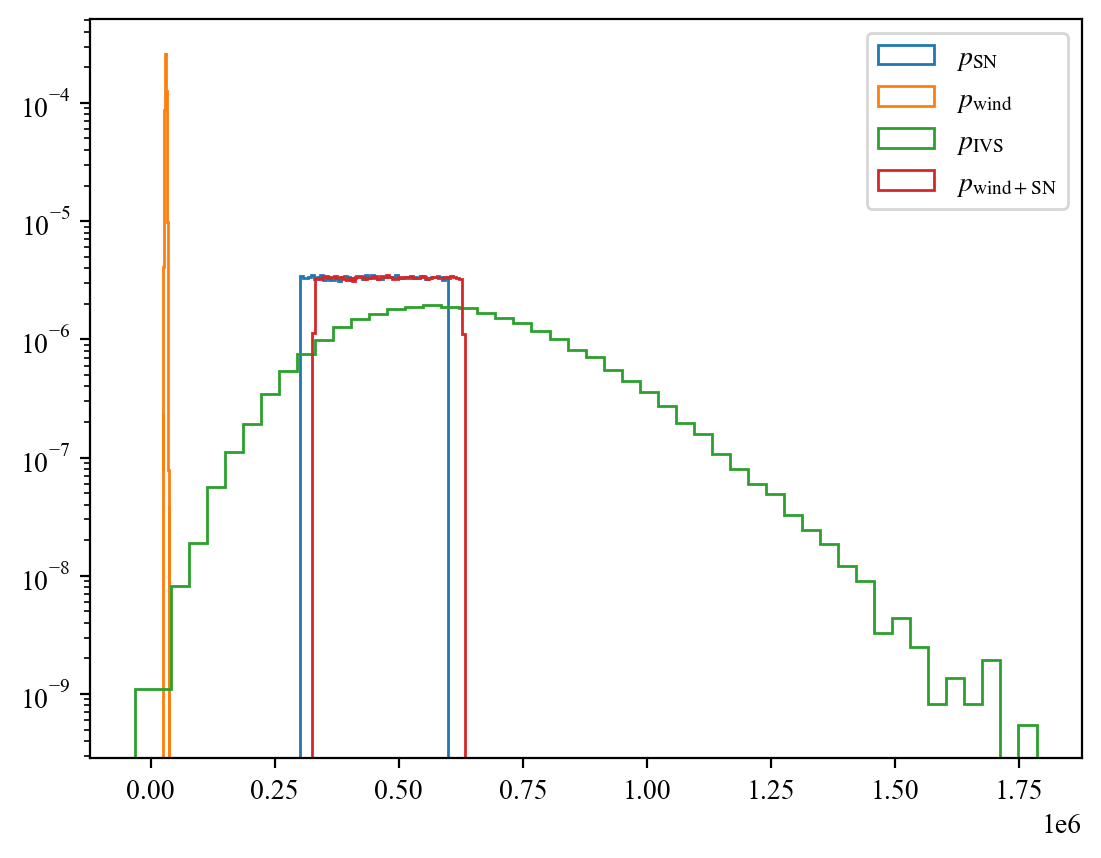

In [68]:
plt.hist(p_SN, bins=50, histtype='step', density=True, label='$p_{\\rm{SN}}$')
plt.hist(p_wind_tot.value, bins=50, histtype='step', density=True, label='$p_{\\rm{wind}}$')
plt.hist(p_ivs.value, bins=50, histtype='step', density=True, label='$p_{\\rm{IVS}}$')
plt.hist(p_SN+p_wind_tot.value, bins=50, histtype='step', density=True, label='$p_{\\rm{wind+ SN}}$')
plt.legend()
plt.semilogy()
plt.show()

In [39]:
p_rocket_zp.to(u.Msun*u.km/u.s), p_rocket_gm_wr.to(u.Msun*u.km/u.s) ,p_rocket_gm_O.to(u.Msun*u.km/u.s)

(<Quantity 88949972.87699719 km solMass / s>,
 <Quantity 837463.41934513 km solMass / s>,
 <Quantity 30136324.96232369 km solMass / s>)

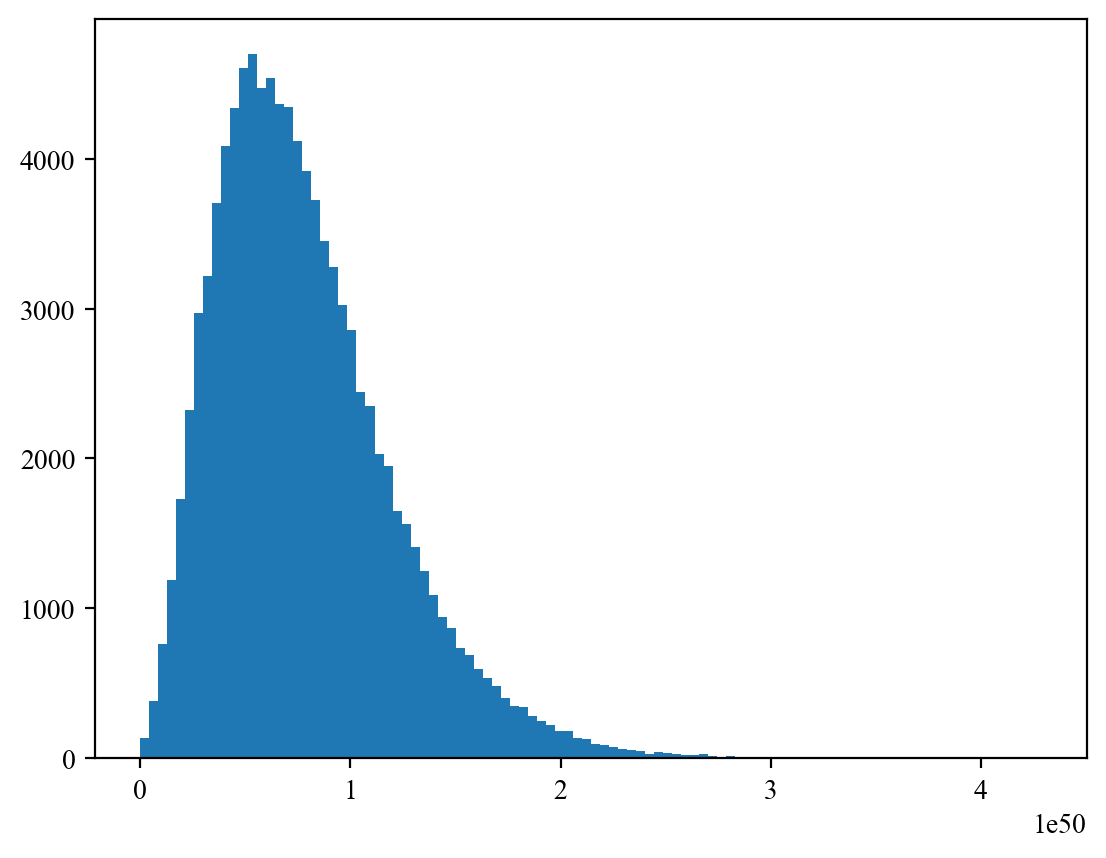

In [231]:
plt.hist(ivs_e_tot.value, bins=100)
plt.show()

In [177]:
# low = np.log10(0.015)
# hi = np.log10(0.3)
# wind_mult_log = 10**(np.random.uniform(low, hi, n_sample))

# low = np.log10(0.001)
# hi = np.log10(0.2)
# sn_mult_log = 10**(np.random.uniform(low, hi, n_sample))

# wind_contri = wind_tot * wind_mult_log
# sn_contri = e_SN * sn_mult_log

# etot_wind_SN = wind_contri + sn_contri

In [188]:
# For stellar wind energy
wind_mult = np.random.uniform(0.015, 0.3, n_sample) #typical 0.03~0.3
sn_mult = np.random.uniform(0.001, 0.20, n_sample) #typical ~0.195
wind_contri = wind_tot*wind_mult
sn_contri = e_SN * sn_mult

etot_wind_SN = wind_contri + sn_contri

In [64]:
# For stellar wind momentum
p_wind_mult = np.random.uniform(0, 1, n_sample)
p_sn_mult = np.random.uniform(0, 4, n_sample)
p_wind_contri = p_wind_tot.value*p_wind_mult
p_sn_contri = p_SN * p_sn_mult

p_tot_wind_SN = p_wind_contri + p_sn_contri

In [200]:
ivs_e_tot_min = np.percentile(ivs_e_tot, 2.5)
ivs_e_tot_med = np.percentile(ivs_e_tot, 50)
ivs_e_tot_max = np.percentile(ivs_e_tot, 97.5)
print(ivs_e_tot_min,ivs_e_tot_max)
print(np.percentile(ivs_e_tot, 50))

1.7216128986677663e+49 erg 1.7942871315521855e+50 erg
7.109692004227775e+49 erg


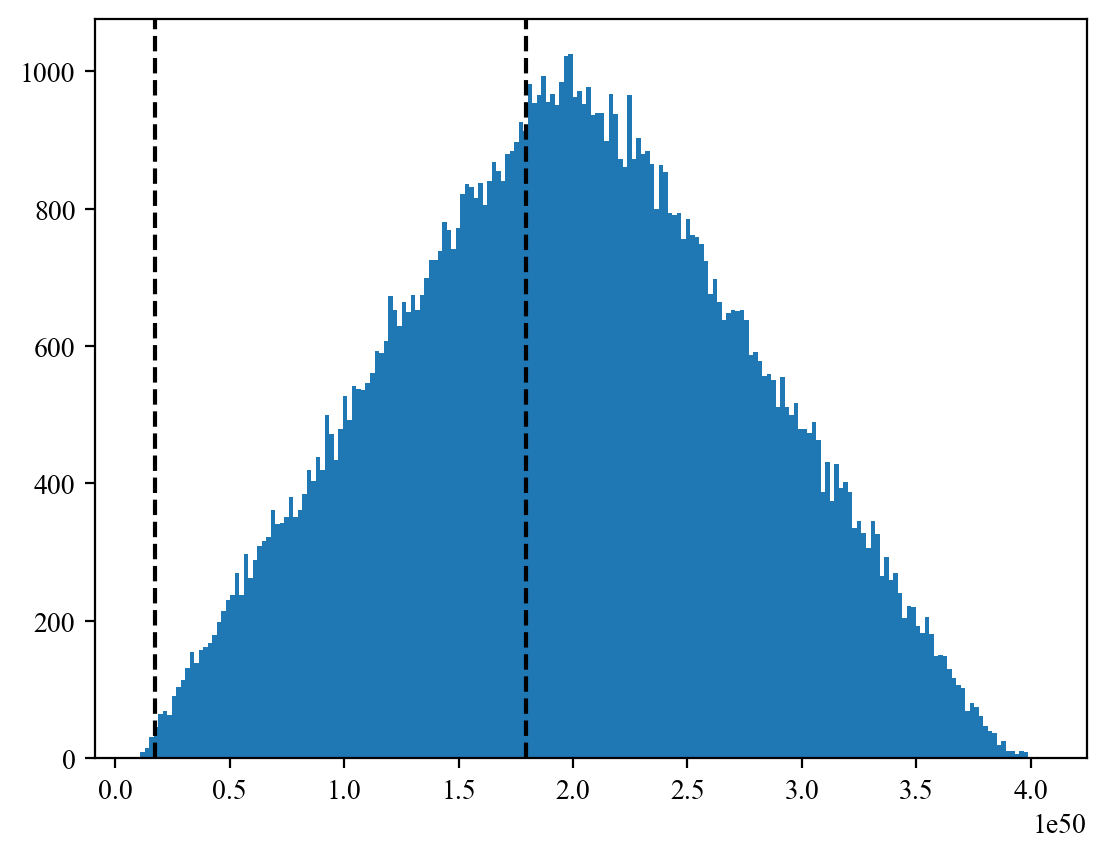

In [197]:
plt.hist(etot_wind_SN.value, bins=200)
plt.axvline(ivs_e_tot_min.value, ls='--', c='k')
plt.axvline(ivs_e_tot_max.value, ls='--', c='k')
plt.show()

40450


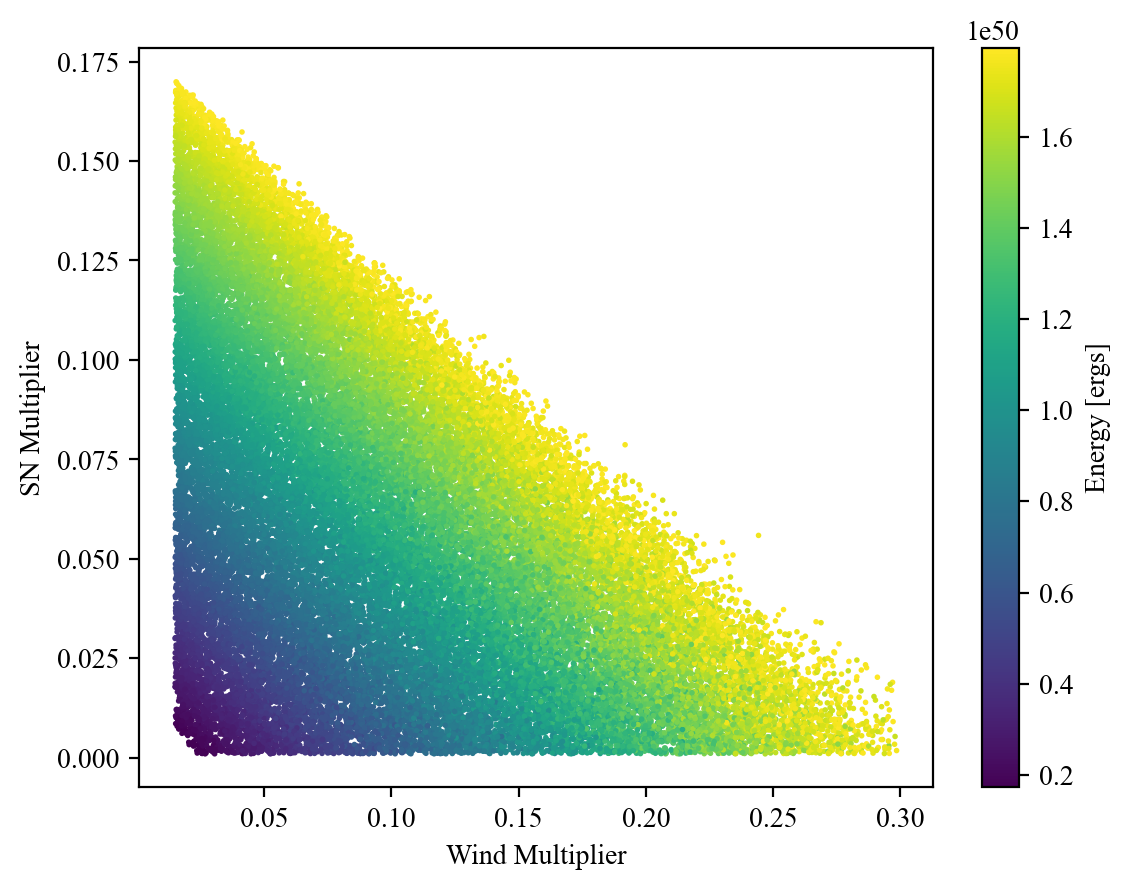

In [226]:
possible_mask = (etot_wind_SN >ivs_e_tot_min) & (etot_wind_SN < ivs_e_tot_max)
print(np.sum(possible_mask))
# alpha = np.abs(etot_wind_SN-ivs_e_tot)/ivs_e_tot
sc = plt.scatter(wind_mult[possible_mask], sn_mult[possible_mask], c=etot_wind_SN[possible_mask], alpha=1, s=1)
# sc = plt.scatter(wind_mult_log[possible_mask], sn_mult_log[possible_mask], c=etot_wind_SN[possible_mask], alpha=1, s=10)
plt.colorbar(sc, label="Energy [ergs]")


median_mask = (etot_wind_SN > 0.99 * ivs_e_tot_med) & (etot_wind_SN < 1.01 * ivs_e_tot_med)
# plt.scatter(wind_mult[median_mask], sn_mult[median_mask], c='w', edgecolors='C1', alpha=1, s=10)


plt.xlabel("Wind Multiplier")
plt.ylabel("SN Multiplier")

# plt.savefig('/Users/anniegao/Documents/GBO&TAC/plots/SN_stellarwind_ratio.pdf', dpi= 300)
plt.show()

92520


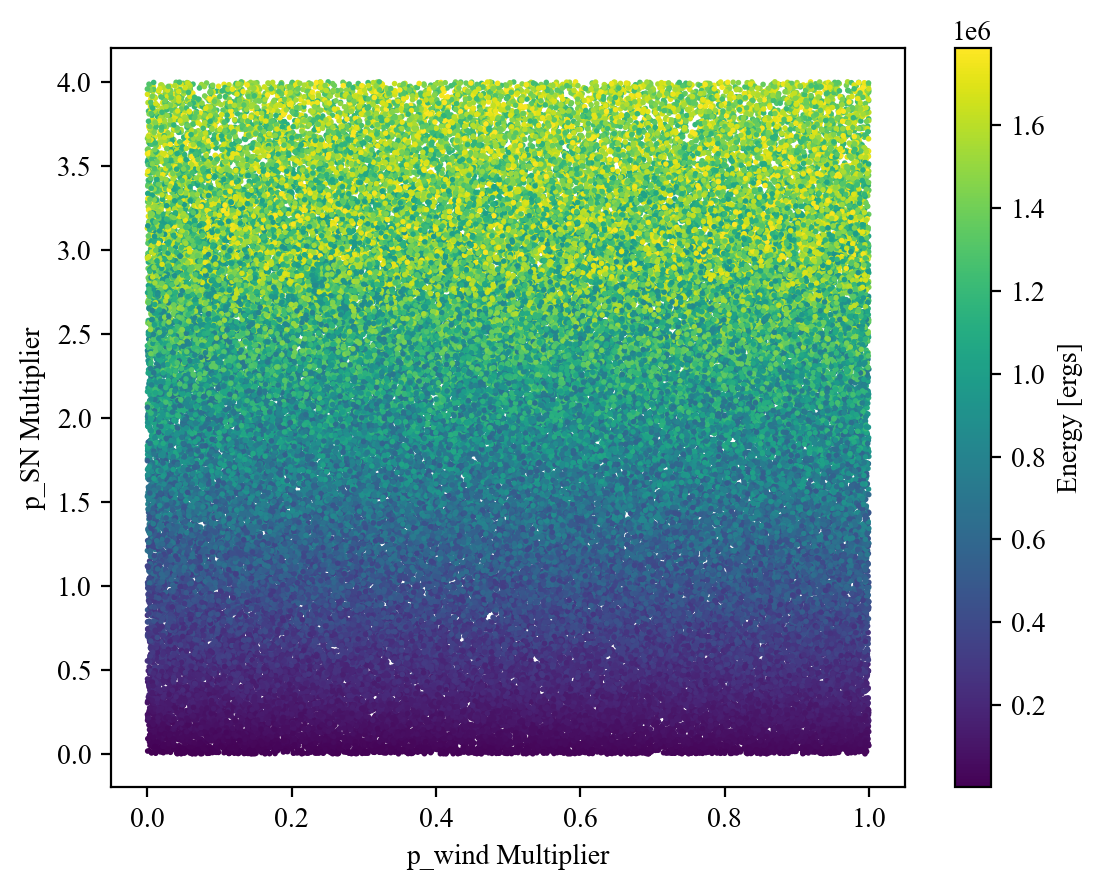

In [65]:
p_possible_mask = (p_tot_wind_SN >min(p_ivs.value)) & (p_tot_wind_SN < max(p_ivs.value))
print(np.sum(p_possible_mask))
sc = plt.scatter(p_wind_mult[p_possible_mask], p_sn_mult[p_possible_mask], c=p_tot_wind_SN[p_possible_mask], alpha=1, s=1)
# sc = plt.scatter(wind_mult_log[possible_mask], sn_mult_log[possible_mask], c=etot_wind_SN[possible_mask], alpha=1, s=10)
plt.colorbar(sc, label="Energy [ergs]")

plt.xlabel("p_wind Multiplier")
plt.ylabel("p_SN Multiplier")
plt.show()

## SN conversion effeciency calculation

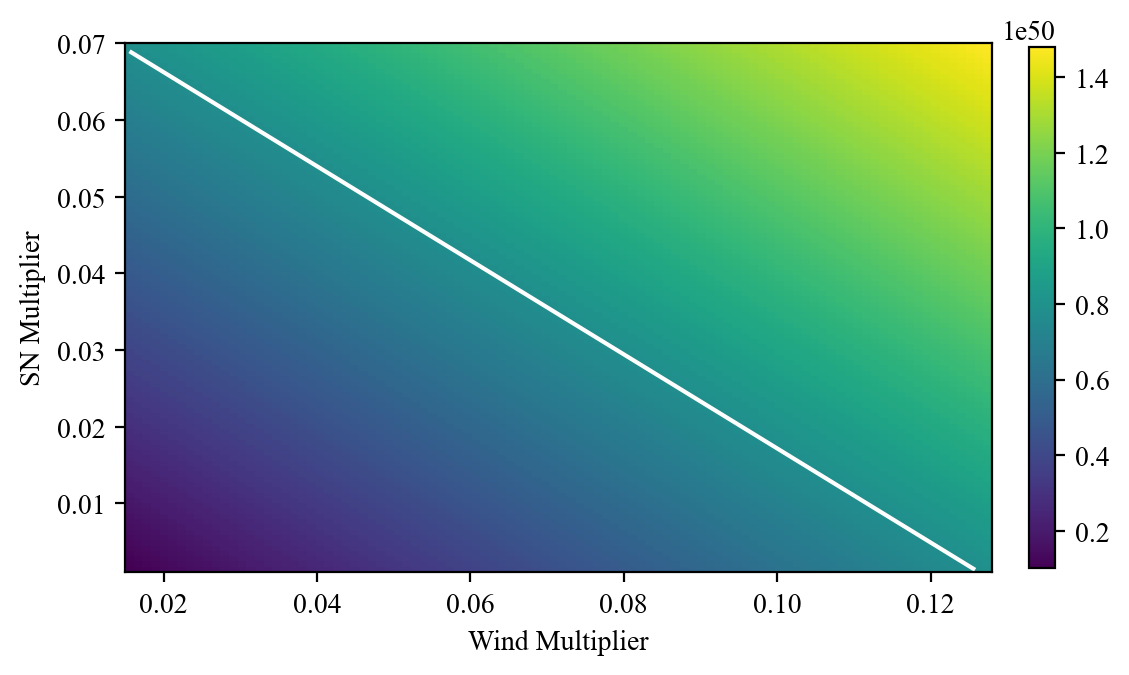

In [1345]:
fig, ax = plt.subplots(figsize=(6,4))

extent=(wind_mult[0], wind_mult[-1], sn_mult[0], sn_mult[-1])

im = ax.imshow(total_e, origin='lower', extent=extent)
fig.colorbar(im, fraction=0.028, pad=0.04)

ax.contour(total_e, levels=[ivs_e_tot.value] ,origin='lower', colors=['white'], extent=extent)

plt.xlabel("Wind Multiplier")
plt.ylabel("SN Multiplier")

plt.show()

In [239]:
Amix = 3.5
lambda_dv = 0.1
nH0 = 0.62
Lin_dEth = Amix * np.sqrt(lambda_dv * nH0)
theta = Lin_dEth/(11/5 + Lin_dEth)
Ekin_sb =  (1-theta) * (3/10) * (50/77) * 1e51 * u.erg
print(theta, Ekin_sb/1e51)

0.2837359485578397 0.1395319580731481 erg


### Weighted mean position of Vela OB2

In [664]:
# mean position of Vela OB2
vela_coord = SkyCoord(ra=velaOB2['_RA']*u.deg, dec = velaOB2['_DE']*u.deg,
                     distance=Distance(parallax=out['Plx'].value*u.mas))

In [745]:
v = Vizier(columns=['HIP', '_RA.icrs', '_DE.icrs', 'e_RAICRS', 'e_DEICRS', 
                    'Plx', 'e_Plx', 'SpType'], catalog="I/239/hip_main")
position_OB2 =v.query_object(f"HIP {velaOB2['HIP'][0]}")[0]
for i in range(1, len(velaOB2['HIP'])):
    if i!= 26 and i!=37 and i!=83:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        position_OB2.add_row([que['_RA.icrs'], que['_DE.icrs'], que['HIP'], que['e_RAICRS'], que['e_DEICRS'],
                              que['Plx'], que['e_Plx'], que['SpType']])
    elif i== 83:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        position_OB2.add_row([que['_RA.icrs'][0], que['_DE.icrs'][0], que['HIP'][0], que['e_RAICRS'][0], 
                              que['e_DEICRS'][0],
                              que['Plx'][0], que['e_Plx'][0], que['SpType'][0]])
    else:
        que = v.query_object(f"HIP {velaOB2['HIP'][i]}")[0]
        position_OB2.add_row([que['_RA.icrs'][1], que['_DE.icrs'][1], que['HIP'][1], que['e_RAICRS'][1], 
                              que['e_DEICRS'][1],
                              que['Plx'][1], que['e_Plx'][1], que['SpType'][1]])

In [804]:
OB2_ra_mean = np.average(position_OB2['_RA.icrs'], weights=position_OB2['e_RAICRS'])
OB2_dec_mean = np.average(position_OB2['_DE.icrs'], weights=position_OB2['e_DEICRS'])
OB2_plx_mean = np.average(position_OB2['Plx'], weights=position_OB2['e_Plx'])

In [784]:
n_sample = 5000
OB2_ra = np.random.normal(loc=position_OB2['_RA.icrs'][:, np.newaxis], scale=position_OB2['e_RAICRS'][:, np.newaxis],size=(len(position_OB2), n_sample))
OB2_dec = np.random.normal(loc=position_OB2['_DE.icrs'][:, np.newaxis], scale=position_OB2['e_DEICRS'][:, np.newaxis],size=(len(position_OB2), n_sample))
OB2_plx = np.random.normal(loc=position_OB2['Plx'][:, np.newaxis], scale=position_OB2['e_Plx'][:, np.newaxis],size=(len(position_OB2), n_sample))

In [790]:
OB2_w_std = SkyCoord(ra=OB2_ra*u.deg, dec=OB2_dec*u.deg, distance=Distance(parallax=np.abs(OB2_plx)*u.mas))
OB2_x = OB2_w_std.galactic.cartesian.x.value
OB2_y = OB2_w_std.galactic.cartesian.y.value
OB2_z = OB2_w_std.galactic.cartesian.z.value
OB2_x_mean = np.average(vela_coord.galactic.cartesian.x.value, weights=np.std(OB2_x, axis=1))
OB2_y_mean = np.average(vela_coord.galactic.cartesian.y.value, weights=np.std(OB2_y, axis=1))
OB2_z_mean = np.average(vela_coord.galactic.cartesian.z.value, weights=np.std(OB2_z, axis=1))

In [818]:
a,b,c = w.world_to_pixel(OB2_x_mean*u.pc, 
                         OB2_y_mean*u.pc,
                        OB2_z_mean*u.pc)

## Rocket Effect calculation

#### Gas Evaporation velocity cs=10 km/s; number of ionizing photons per second from stars (Draine Table 15.1)
#### total injected momentum p_tot = N_absorb * m_p * v = \phi * Q * t_life * cs * m_p

In [40]:
cs = 10*(u.km/u.s)
p_rocket_gm_O = (10**(49)/(u.s) * cs * 3.59*(u.Myr) * m_p).to(u.kg*u.m/u.s)
p_rocket_gm_wr = (10**(48.8)/(u.s) * cs * 0.5*(u.Myr) * m_p).to(u.kg*u.m/u.s)
p_rocket_zp = (10**(49.7)/(u.s) * cs * 3.2*(u.Myr) * m_p).to(u.kg*u.m/u.s)

In [41]:
p_rocket_zp, p_rocket_gm_wr, p_rocket_gm_O

(<Quantity 8.46548277e+40 kg m / s>,
 <Quantity 1.66522053e+39 kg m / s>,
 <Quantity 1.89494322e+40 kg m / s>)

In [42]:
(5e40*u.g*u.cm/u.s).to(u.Msun*u.km/u.s)

<Quantity 251.45721079 km solMass / s>

## Vela SNR

In [5]:
v = Vizier(columns=["**"], catalog="VII/253")
velasnr=v.query_object("NAME Vela XYZ")[0]
customSimbad = Simbad() # to get rv & rv_error information
customSimbad.add_votable_fields('rv_value','rvz_error','rvz_bibcode', 'plx', 'pm','pmra','pmdec')
result_table = customSimbad.query_object('NAME Vela XYZ').to_pandas()

In [16]:
vela_SNR= SkyCoord(ra='08h34m0s',dec='-45d50m0s',frame='icrs')
vela_SNR#.galactic #.x.to(u.parsec).value

<SkyCoord (ICRS): (ra, dec) in deg
    (128.5, -45.83333333)>

## Create Table 4 and Table 5 in the paper

In [52]:
Hunt_catalog = fits.open('/Users/anniegao/Dropbox/Gum_Nebula/data/Zeta_Pup_vicinity/asu-2.fit')[1].data
tr10_info = Hunt_catalog[Hunt_catalog.Name =='Trumpler_10']

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1606: VerifyWarning: Invalid keyword for column 5: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768').
  warnings.warn(



In [ ]:
tr10_coord = SkyCoord(ra=tr10_info['RA_ICRS']*u.deg, dec=tr10_info['DE_ICRS']*u.deg, distance=Distance(parallax=tr10_info['Plx']*u.mas),
                      pm_ra_cosdec= tr10_info.pmRA*u.mas/u.yr, pm_dec=tr10_info.pmDE*u.mas/u.yr,
                      radial_velocity=tr10_info.RV*u.km/u.s, frame='icrs')
tr10_cartesian = tr10_coord.transform_to(Galactic)
tr10_cartesian.representation_type = 'cartesian'
tr10_cartesian
ns_coord = SkyCoord(ra='07h20m24.9620s', dec='-31d25m50.083s', distance=Distance(parallax= 3.6*u.mas),
                    pm_ra_cosdec= -92.8*u.mas/u.yr, pm_dec= 55.3*u.mas/u.yr, radial_velocity=0*u.km/u.s,
                    frame='icrs')
ns_cartesian = ns_coord.transform_to(Galactic)
ns_cartesian.representation_type='cartesian'
ns_cartesian

In [ ]:
table4 = Table(names=['ra[deg]','dec[deg]', 'plx[mas]', 'plx_error',
                      'X_helio[pc]', 'Y_helio[pc]', 'Z_helio[pc]', 
                      'pmra[mas/yr]', 'pmra_error', 'pmde[mas/yr]', 'pmde_error',
                      'rv[km/s]', 'rv_error',
                      'U[km/s]', 'V[km/s]', 'W[km/s]' ])
table4.add_row([ zp_coord.ra.value,zp_coord.dec.value, zeta[0]['Plx'].value, zeta[0]['e_Plx'].value,
                zp_cartesian.u.value, zp_cartesian.v.value, zp_cartesian.w.value, 
                zp_coord.pm_ra_cosdec.value, zeta[0]['e_pmRA'].value, zp_coord.pm_dec.value, zeta[0]['e_pmDE'].value, 
                -25.4, 2.1, 
                zp_cartesian.U.value, zp_cartesian.V.value, zp_cartesian.W.value])
table4.add_row([tr10_info['RA_ICRS'], tr10_info['DE_ICRS'], tr10_info['Plx'], tr10_info['s_Plx'], 
                tr10_cartesian.u.value, tr10_cartesian.v.value, tr10_cartesian.w.value, 
                tr10_info.pmRA, tr10_info.s_pmRA, tr10_info.pmDE, tr10_info.s_pmDE, 
                tr10_info.RV, tr10_info.s_RV,
                tr10_cartesian.U.value, tr10_cartesian.V.value, tr10_cartesian.W.value])
table4.add_row([ns_coord.ra.value, ns_coord.dec.value, 3.6, 1.6, 
                ns_cartesian.u.value, ns_cartesian.v.value, ns_cartesian.w.value, 
                ns_coord.pm_ra_cosdec.value, 1.2, ns_coord.pm_dec.value,1.3, 
                np.nan, np.nan,
                np.nan, np.nan, np.nan])
a = np.array(['zeta_puppis', 'Trumpler_10', 'RX_J0720.4-3125']) #, dtype=np.str
table4.add_column(a, name='Name' )
table4_reorder = table4['Name' ,'ra[deg]','dec[deg]', 'plx[mas]', 'plx_error',
                      'X_helio[pc]', 'Y_helio[pc]', 'Z_helio[pc]', 
                      'pmra[mas/yr]', 'pmra_error', 'pmde[mas/yr]', 'pmde_error',
                      'rv[km/s]', 'rv_error',
                      'U[km/s]', 'V[km/s]', 'W[km/s]' ]
# ascii.write(table4_reorder, '/Users/anniegao/Dropbox/Gum_Nebula/data/table4.dat', overwrite=True)  

In [84]:
swiggum_catalog = pd.read_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/cluster_sample_data_Swiggum2024.csv')
swiggum_catalog[swiggum_catalog['name']=='Alessi_36']['x_helio']

14   -97.941623
Name: x_helio, dtype: float64

In [ ]:
table5 = swiggum_catalog[(swiggum_catalog['name']=='Alessi_36') | (swiggum_catalog['name']=='Collinder_135') | (swiggum_catalog['name']=='Collinder_140') |
                         (swiggum_catalog['name']=='NGC_2451B') | (swiggum_catalog['name']=='OC_0450') | (swiggum_catalog['name']=='OCSN_82') |
                         (swiggum_catalog['name']=='Pozzo_1') | (swiggum_catalog['name']=='OC_0470') | (swiggum_catalog['name']=='CWNU_1083') | 
                         (swiggum_catalog['name']=='CWNU_1096') | (swiggum_catalog['name']=='OC_0479')]

table5.reset_index(drop=True, inplace=True)
table5_1 = table5.iloc[[0, 3, 4, 5, 6, 9, 10, 7, 1, 2, 8]]
table5_1 = table5_1[['name', 'family', 'n_stars', 'age_myr', 'x_helio', 'y_helio', 'z_helio', 'U', 'V', 'W']]
table5_1.insert(loc=4, column='E_SN', value=np.array([0.11, 0.11, 0.17, 0.42, 0.23, 0.12, 0.44, 0.41, 0.08, 0.04, 0.24]))
# table5_1.to_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/table5.csv', index=False)

## Young stars in CG30 (average movement)

In [2]:
CG = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Young_star_standard.csv', index_col='Name')

In [3]:
# CG = CG.drop([0, 2, 3], axis=0)
# CG['pmRA[mas/yr]']=pd.to_numeric(CG['pmRA[mas/yr]'], downcast="float")
# CG['pmDec[mas/yr]']=pd.to_numeric(CG['pmDec[mas/yr]'], downcast="float")
# CG['RV[km/s]']=pd.to_numeric(CG['RV[km/s]'], downcast="float")

### <font color= '0e6251'> Choose only the CG 30 association stars, update w/ Gaia DR3

In [5]:
CG30 = CG.loc[['PHa 14', 'PHa 15', 'KWW 464', 'KWW 598', 'KWW 1863', 'KWW 2205']]
CG30

,RA[deg],Dec[deg],Dist[pc],x[pc],y[pc],z[pc],longitude[deg],latitude[deg],RV[km/s],pmRA[mas/yr],pmDec[mas/yr],dx[km/s],dy[km/s],dz[km/s]
Name,,,,,,,,,,,,,,
PHa 14,122.141125,-36.136111,370.0,-106.706466,-354.086804,-11.673276,253.229462,-1.807947,26.77,-7.320,11.720,-19.826950,-6.396636,6.752493
PHa 15,122.195083,-36.131303,354.4,-102.093696,-339.199918,-10.938584,253.249054,-1.768720,21.99,-7.579,11.451,-17.322002,-2.150400,6.305984
KWW 464,122.002792,-35.959356,360.5,-105.226168,-344.613666,-11.363300,253.020195,-1.806316,24.00,-7.510,11.603,-18.494769,-3.802376,6.419782
KWW 598,122.156625,-36.164022,354.1,-101.941757,-338.923658,-11.200093,253.259718,-1.812553,21.50,-7.890,10.980,-16.785912,-1.774998,5.428865
KWW 1863,122.157583,-36.065347,356.9,-103.242931,-341.465326,-10.951637,253.177171,-1.758423,26.20,-7.400,12.025,-19.344535,-5.929710,6.951312
KWW 2205,122.189167,-36.035961,365.5,-105.799054,-349.680301,-10.977136,253.166317,-1.721035,25.30,-7.728,11.675,-19.438640,-4.932175,6.209710


In [6]:
np.mean(CG30['Dist[pc]'].values)

360.23333333333335

In [9]:
KWW1863_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/KWW1863_gaia.fit')[1].data[0]
KWW1863_update_co = calculate_properties(SkyCoord(ra = KWW1863_gaia['RA_ICRS']*u.deg, dec=KWW1863_gaia['DE_ICRS']*u.deg, 
                                         distance=Distance(parallax=KWW1863_gaia['Plx']*u.mas ),pm_ra_cosdec=KWW1863_gaia['pmRA']*u.mas/u.yr,
                                         pm_dec=KWW1863_gaia['pmDE']*u.mas/u.yr,radial_velocity = KWW1863_gaia['RV']*u.km/u.s,
                                                  frame='icrs'))
# CG30.loc['KWW_1863_GAIA'] = KWW1863_update_co.iloc[0].values

In [11]:
KWW2205_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/KWW2205.fit')[1].data[0]
KWW2205_update_co = calculate_properties(SkyCoord(ra = KWW2205_gaia['RA_ICRS']*u.deg, dec=KWW2205_gaia['DE_ICRS']*u.deg, 
                                         distance=Distance(parallax=KWW2205_gaia['Plx']*u.mas ),pm_ra_cosdec=KWW2205_gaia['pmRA']*u.mas/u.yr,
                                         pm_dec=KWW2205_gaia['pmDE']*u.mas/u.yr,radial_velocity = KWW2205_gaia['RV']*u.km/u.s,
                                                  frame='icrs'))
# CG30.loc['KWW_2205_GAIA'] = KWW2205_update_co.iloc[0].values

In [12]:
KWW464_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/KWW464.fit')[1].data[0]
KWW464_update_co = calculate_properties(SkyCoord(ra = KWW464_gaia['RA_ICRS']*u.deg, dec=KWW464_gaia['DE_ICRS']*u.deg, 
                                                 distance=Distance(parallax=KWW464_gaia['Plx']*u.mas ),pm_ra_cosdec=KWW464_gaia['pmRA']*u.mas/u.yr,
                                                 pm_dec=KWW464_gaia['pmDE']*u.mas/u.yr,radial_velocity=KWW464_gaia['RV']*u.km/u.s, frame='icrs'))
# CG30.loc['KWW_464_GAIA'] = KWW464_update_co.iloc[0].values

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 44: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 47: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 51: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(



In [13]:
KWW598_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/KWW598.fit')[1].data[0]
KWW598_update_co = calculate_properties(SkyCoord(ra = KWW598_gaia['RA_ICRS']*u.deg, dec=KWW598_gaia['DE_ICRS']*u.deg, 
                                                 distance=Distance(parallax=KWW598_gaia['Plx']*u.mas ),pm_ra_cosdec=KWW598_gaia['pmRA']*u.mas/u.yr,
                                                 pm_dec=KWW598_gaia['pmDE']*u.mas/u.yr,radial_velocity=KWW598_gaia['RV']*u.km/u.s, frame='icrs'))
# CG30.loc['KWW_598_GAIA'] = KWW598_update_co.iloc[0].values

In [14]:
PHa14_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/Pha14.fit')[1].data[0]
PHa14_gaia_co = calculate_properties(SkyCoord(ra = PHa14_gaia['RA_ICRS']*u.deg, dec=PHa14_gaia['DE_ICRS']*u.deg, 
                                              distance=Distance(parallax=PHa14_gaia['Plx']*u.mas ),pm_ra_cosdec=PHa14_gaia['pmRA']*u.mas/u.yr,
                                              pm_dec=PHa14_gaia['pmDE']*u.mas/u.yr,radial_velocity=PHa14_gaia['RV']*u.km/u.s, frame='icrs'))
# CG30.loc['PHa14_GAIA'] = PHa14_gaia_co.iloc[0].values

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 45: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 48: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/astropy/io/fits/column.py:1495: VerifyWarning: Invalid keyword for column 52: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-2147483648').
  warnings.warn(



In [15]:
PHa15_gaia = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/PHa15.fit')[1].data[1]
PHa15_gaia_co = calculate_properties(SkyCoord(ra = PHa15_gaia['RA_ICRS']*u.deg, dec=PHa15_gaia['DE_ICRS']*u.deg, 
                                              distance=Distance(parallax=PHa15_gaia['Plx']*u.mas ),pm_ra_cosdec=PHa15_gaia['pmRA']*u.mas/u.yr,
                                              pm_dec=PHa15_gaia['pmDE']*u.mas/u.yr,radial_velocity=PHa15_gaia['RV']*u.km/u.s, frame='icrs'))
# CG30.loc['PHa15_GAIA'] = PHa15_gaia_co.iloc[0].values

### <font color= '0e6251'> Weighted mean from GAIA updated version vs Yep 2020 version

In [16]:
print('KWW2205:', KWW2205_gaia['RV'], KWW2205_gaia['e_RV'], '\n', 'KWW464:',KWW464_gaia['RV'], KWW464_gaia['e_RV'], 
     '\n',   'PHa14:', PHa14_gaia['RV'], PHa14_gaia['e_RV'],)

KWW2205: 13.71 3.69 
 KWW464: 15.48 4.84 
 PHa14: 109.36 9.19


In [17]:
### Gaia updated version:
ra_gaia = np.average(np.array([KWW1863_gaia['RA_ICRS'], KWW2205_gaia['RA_ICRS'], KWW464_gaia['RA_ICRS'], 
                               KWW598_gaia['RA_ICRS'], PHa14_gaia['RA_ICRS'], PHa15_gaia['RA_ICRS']]), 
                     weights = 1/np.array([KWW1863_gaia['e_RA_ICRS'], KWW2205_gaia['e_RA_ICRS'], KWW464_gaia['e_RA_ICRS'], 
                                         KWW598_gaia['e_RA_ICRS'], PHa14_gaia['e_RA_ICRS'], PHa15_gaia['e_RA_ICRS']])**2)
dec_gaia = np.average(np.array([KWW1863_gaia['DE_ICRS'], KWW2205_gaia['DE_ICRS'], KWW464_gaia['DE_ICRS'], 
                               KWW598_gaia['DE_ICRS'], PHa14_gaia['DE_ICRS'], PHa15_gaia['DE_ICRS']]), 
                     weights = 1/np.array([KWW1863_gaia['e_DE_ICRS'], KWW2205_gaia['e_DE_ICRS'], KWW464_gaia['e_DE_ICRS'], 
                                         KWW598_gaia['e_DE_ICRS'], PHa14_gaia['e_DE_ICRS'], PHa15_gaia['e_DE_ICRS']])**2)

pmra_gaia = np.average(np.array([KWW1863_gaia['pmRA'], KWW2205_gaia['pmRA'], KWW464_gaia['pmRA'], 
                               KWW598_gaia['pmRA'], PHa14_gaia['pmRA'], PHa15_gaia['pmRA']]), 
                     weights = 1/np.array([KWW1863_gaia['e_pmRA'], KWW2205_gaia['e_pmRA'], KWW464_gaia['e_pmRA'], 
                                         KWW598_gaia['e_pmRA'], PHa14_gaia['e_pmRA'], PHa15_gaia['e_pmRA']])**2)

pmdec_gaia = np.average(np.array([KWW1863_gaia['pmDE'], KWW2205_gaia['pmDE'], KWW464_gaia['pmDE'], 
                               KWW598_gaia['pmDE'], PHa14_gaia['pmDE'], PHa15_gaia['pmDE']]), 
                     weights = 1/np.array([KWW1863_gaia['e_pmDE'], KWW2205_gaia['e_pmDE'], KWW464_gaia['e_pmDE'], 
                                         KWW598_gaia['e_pmDE'], PHa14_gaia['e_pmDE'], PHa15_gaia['e_pmDE']])**2)

plx_gaia = np.average(np.array([KWW1863_gaia['Plx'], KWW2205_gaia['Plx'], KWW464_gaia['Plx'], 
                               KWW598_gaia['Plx'], PHa14_gaia['Plx'], PHa15_gaia['Plx']]), 
                     weights = 1/np.array([KWW1863_gaia['e_Plx'], KWW2205_gaia['e_Plx'], KWW464_gaia['e_Plx'], 
                                         KWW598_gaia['e_Plx'], PHa14_gaia['e_Plx'], PHa15_gaia['e_Plx']])**2)

v_gaia = np.average(np.array([KWW2205_gaia['RV'], KWW464_gaia['RV']]), #, PHa14_gaia['RV']
                    weights= 1/np.array([KWW2205_gaia['e_RV'], KWW464_gaia['e_RV']])**2) #, PHa14_gaia['e_RV']

In [42]:
plx_gaia_std = np.sqrt(np.average((np.array([KWW1863_gaia['Plx'], KWW2205_gaia['Plx'], KWW464_gaia['Plx'], 
                               KWW598_gaia['Plx'], PHa14_gaia['Plx'], PHa15_gaia['Plx']])-plx_gaia)**2, 
                     weights = 1/np.array([KWW1863_gaia['e_Plx'], KWW2205_gaia['e_Plx'], KWW464_gaia['e_Plx'], 
                                         KWW598_gaia['e_Plx'], PHa14_gaia['e_Plx'], PHa15_gaia['e_Plx']])**2))
Distance(parallax=(plx_gaia-plx_gaia_std)*u.mas)-Distance(parallax= plx_gaia*u.mas), Distance(parallax= (plx_gaia+plx_gaia_std)*u.mas)-Distance(parallax= plx_gaia*u.mas), Distance(parallax= plx_gaia*u.mas)

(<Distance 2.49022019 pc>,
 <Distance -2.45616233 pc>,
 <Distance 359.17611843 pc>)

In [18]:
ra_gaia, dec_gaia, plx_gaia, pmra_gaia,  pmdec_gaia , v_gaia

(122.10386669376382,
 -36.050486140699405,
 2.784149470645329,
 -7.579232576422765,
 11.683973891895715,
 14.360631504493584)

In [1201]:
# CG30_mean_gaia = SkyCoord(ra=ra_gaia*u.deg, dec=dec_gaia*u.deg,distance=Distance(parallax=plx_gaia*u.mas),
#                        pm_ra_cosdec=pmra_gaia*u.mas/u.yr, pm_dec=pmdec_gaia*u.mas/u.yr,radial_velocity=v_gaia*u.km/u.s, frame='icrs')
# CG30_mean_gaia.transform_to('galacticlsr')

In [19]:
### Yep version:
v_yep = np.average(np.array([26.77, 21.99, 24.0, 21.5, 26.2, 25.3 ]),
                    weights= 1/np.array([0.89, 0.20, 3.0, 3.0, 3.0, 3.0])**2)
CG30_mean_yep = SkyCoord(ra=ra_gaia*u.deg, dec=dec_gaia*u.deg,distance=Distance(parallax=plx_gaia*u.mas),
                       pm_ra_cosdec=pmra_gaia*u.mas/u.yr, pm_dec=pmdec_gaia*u.mas/u.yr,radial_velocity=v_yep*u.km/u.s, frame='icrs')
CG30_mean_yep.transform_to('galacticlsr')

<SkyCoord (GalacticLSR: v_bary=(11.1, 12.24, 7.25) km / s): (l, b, distance) in (deg, deg, pc)
    (253.14113594, -1.78687166, 359.17611843)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-9.77271042, 3.93839787, 7.10164175)>

In [34]:
yep_variance = np.sqrt(np.average((np.array([26.77, 21.99, 24.0, 21.5, 26.2, 25.3 ])-v_yep)**2, 
                          weights=1/np.array([0.89, 0.20, 3.0, 3.0, 3.0, 3.0])**2))
yep_variance

1.0713223127091418

In [ ]:
### TK paper: 
v_TK = 5.8 *u.km/u.s # CG30
v_TK_CG31 = 6.0 *u.km/u.s